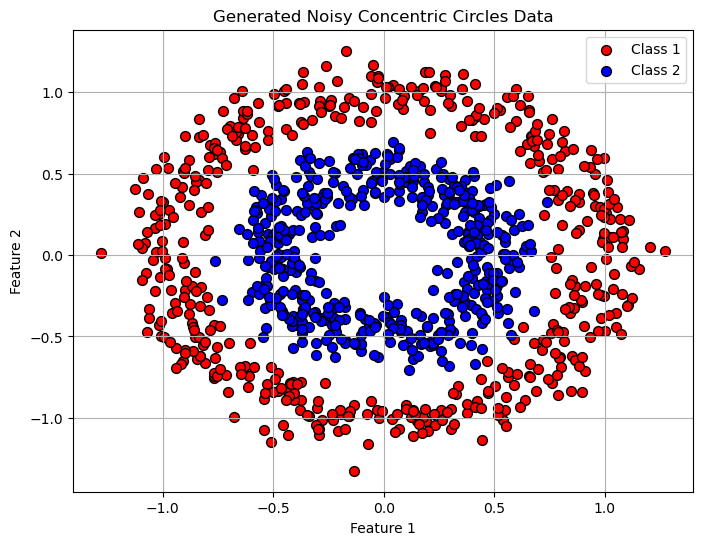

In [115]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
import torch
# 生成同心圆数据
# n_samples 表示样本总数
# factor 表示内圈和外圈的间距
# noise 表示噪声的数量
X, y = make_circles(n_samples=1000, factor=0.5, noise=0.1)
# 数据 (这里使用之前生成的同心圆数据)
X_tensor = torch.FloatTensor(X)
y_tensor = torch.FloatTensor(y).unsqueeze(1)
# 分割数据为训练集和测试集
split_ratio = 0.8
split = int(split_ratio * len(X_tensor))
X_train, X_test = X_tensor[:split], X_tensor[split:]
y_train, y_test = y_tensor[:split], y_tensor[split:]

# 可视化数据
plt.figure(figsize=(8, 6))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='red', s=50, edgecolors='k', label='Class 1')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='blue', s=50, edgecolors='k', label='Class 2')
plt.title("Generated Noisy Concentric Circles Data")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)
plt.show()


Epoch [100/1000], Loss: 0.6547
Epoch [200/1000], Loss: 0.3781
Epoch [300/1000], Loss: 0.1759
Epoch [400/1000], Loss: 0.1078
Epoch [500/1000], Loss: 0.0761
Epoch [600/1000], Loss: 0.0591
Epoch [700/1000], Loss: 0.0490
Epoch [800/1000], Loss: 0.0421
Epoch [900/1000], Loss: 0.0369
Epoch [1000/1000], Loss: 0.0329


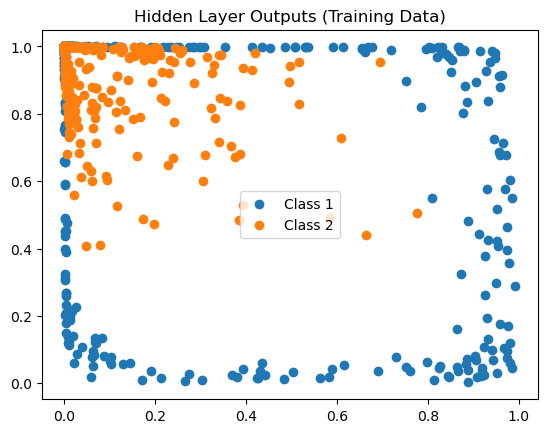

In [116]:
import torch
import torch.nn as nn
# 定义MLP模型
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

    def extract_hidden(self, x):
        return torch.sigmoid(self.fc1(x))

# 模型初始化
input_dim = 2
hidden_dim = 10
model = MLP(input_dim, hidden_dim)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# 训练模型
epochs = 1000
weights = []
weight_changes = []
for epoch in range(epochs):
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    weights.append(model.fc1.weight.detach().clone())
    weight_changes.append(model.fc1.weight.grad.norm().item())

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
# 可视化隐层输出
hidden_outputs = model.extract_hidden(X_train).detach().numpy()
plt.scatter(hidden_outputs[y_train.squeeze() == 0][:, 0], hidden_outputs[y_train.squeeze() == 0][:, 1], label='Class 1')
plt.scatter(hidden_outputs[y_train.squeeze() == 1][:, 0], hidden_outputs[y_train.squeeze() == 1][:, 1], label='Class 2')
plt.title("Hidden Layer Outputs (Training Data)")
plt.legend()
plt.show()

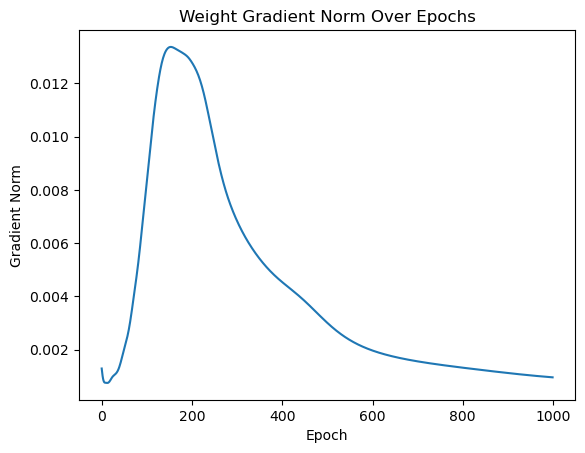

In [117]:
# 可视化权重变化
plt.plot(weight_changes)
plt.title('Weight Gradient Norm Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Gradient Norm')
plt.show()

In [118]:
from sklearn.metrics import silhouette_score, pairwise_distances
import numpy as np

# Ensure y_train is a 1D array
y_train_1d = y_train.ravel() if y_train.ndim > 1 else y_train

# Calculate the silhouette score
silhouette_avg = silhouette_score(hidden_outputs, y_train_1d)

# Calculate the mean distance within each class (density and dispersion)
class_1_points = hidden_outputs[y_train_1d == 0]
class_2_points = hidden_outputs[y_train_1d == 1]

# Density - average distance between points in the same class
density_class_1 = np.mean(pairwise_distances(class_1_points))
density_class_2 = np.mean(pairwise_distances(class_2_points))

# Cluster centroids
centroid_class_1 = np.mean(class_1_points, axis=0)
centroid_class_2 = np.mean(class_2_points, axis=0)

# Outliers - points far from the centroid
# Define a threshold distance for considering a point as an outlier
threshold_distance = 2
outliers_class_1 = np.sum(np.linalg.norm(class_1_points - centroid_class_1, axis=1) > threshold_distance)
outliers_class_2 = np.sum(np.linalg.norm(class_2_points - centroid_class_2, axis=1) > threshold_distance)

# Feature transformation - variance along the axes of the new feature space
variance_class_1 = np.var(class_1_points, axis=0)
variance_class_2 = np.var(class_2_points, axis=0)

# Print the calculated metrics
print(f"Silhouette Score: {silhouette_avg}")
print(f"Density Class 1: {density_class_1}")
print(f"Density Class 2: {density_class_2}")
print(f"Centroid Class 1: {centroid_class_1}")
print(f"Centroid Class 2: {centroid_class_2}")
print(f"Outliers Class 1: {outliers_class_1}")
print(f"Outliers Class 2: {outliers_class_2}")
print(f"Variance Class 1: {variance_class_1}")
print(f"Variance Class 2: {variance_class_2}")


Silhouette Score: 0.2530709207057953
Density Class 1: 1.5842764377593994
Density Class 2: 0.5099979043006897
Centroid Class 1: [0.27002826 0.72097695 0.28917536 0.7113276  0.26017904 0.2954696
 0.2639683  0.24363135 0.27244312 0.7172541 ]
Centroid Class 2: [0.06946099 0.9302702  0.07857057 0.9048907  0.07391061 0.08516082
 0.06033919 0.05004796 0.06651203 0.91762483]
Outliers Class 1: 0
Outliers Class 2: 0
Variance Class 1: [0.14235324 0.15032767 0.15314597 0.14487648 0.13284329 0.15647209
 0.14214104 0.1287469  0.14301704 0.15014756]
Variance Class 2: [0.01576028 0.01415941 0.01863592 0.02219635 0.01542397 0.01995507
 0.01149156 0.00913583 0.01371829 0.01795358]


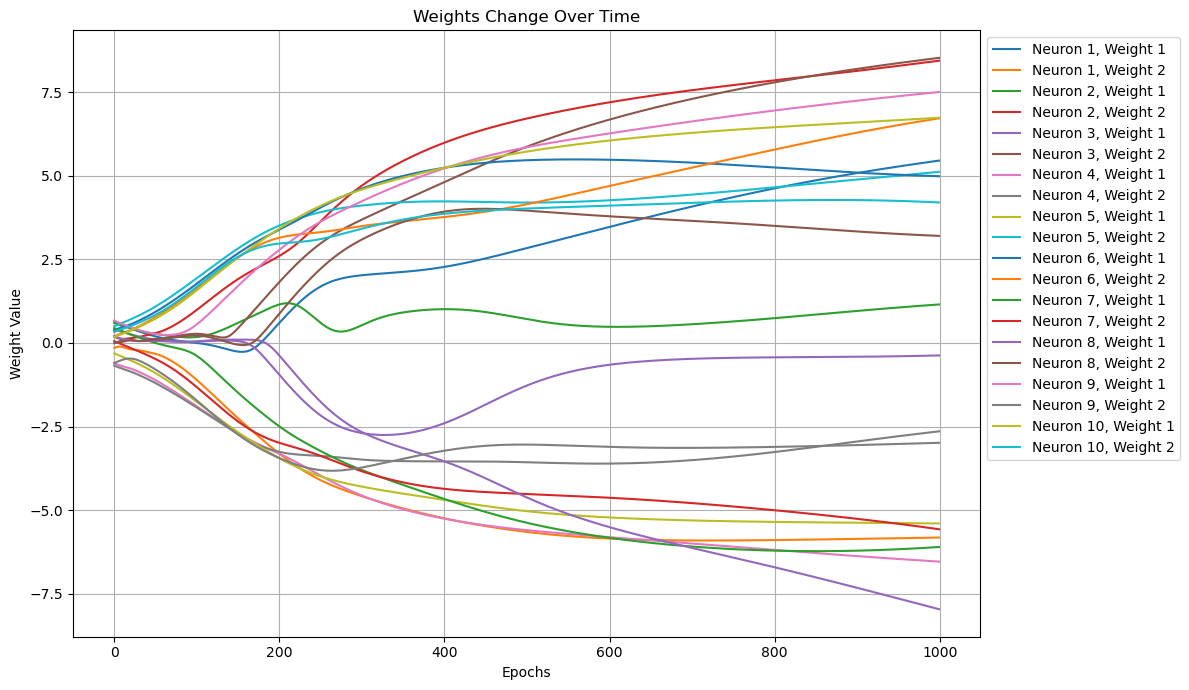

In [119]:
# 将权重转换为numpy数组
weights_np = np.array([w.numpy() for w in weights])
plt.figure(figsize=(12, 7))

for i in range(hidden_dim):
    for j in range(input_dim):
        plt.plot(weights_np[:, i, j], label=f'Neuron {i+1}, Weight {j+1}')

plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.title("Weights Change Over Time")
plt.xlabel("Epochs")
plt.ylabel("Weight Value")
plt.grid(True)
plt.tight_layout()
plt.show()

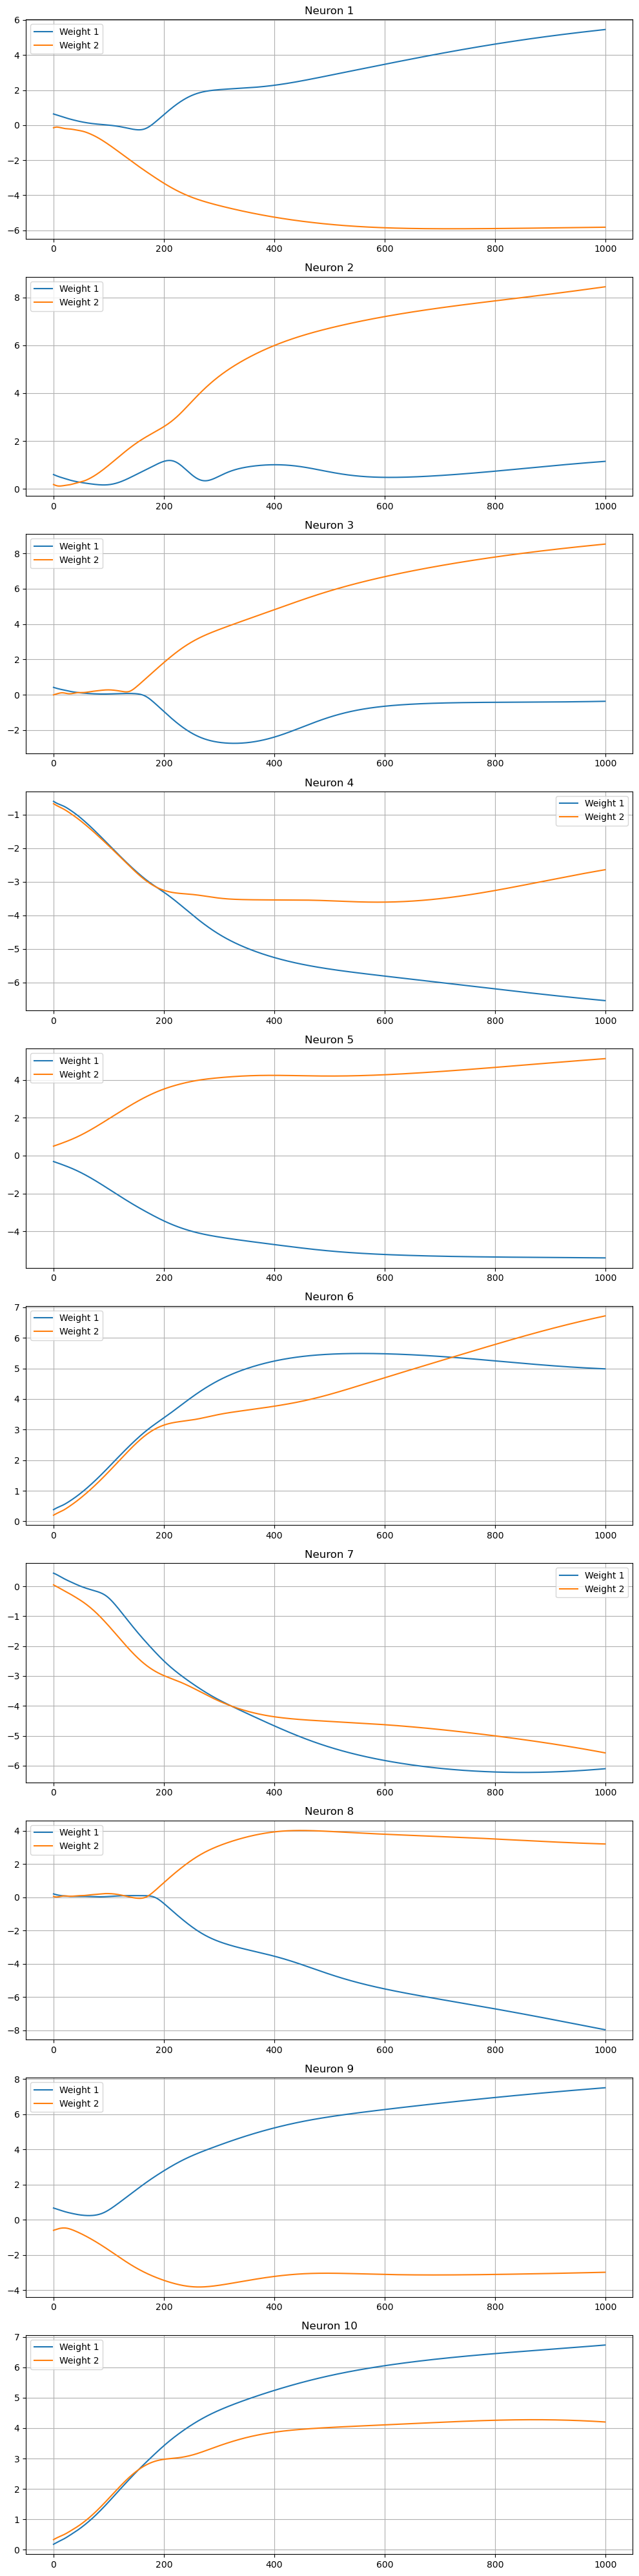

In [120]:
fig, axs = plt.subplots(hidden_dim, figsize=(10, hidden_dim*4))

for i in range(hidden_dim):
    for j in range(input_dim):
        axs[i].plot(weights_np[:, i, j], label=f'Weight {j+1}')
    axs[i].set_title(f'Neuron {i+1}')
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()

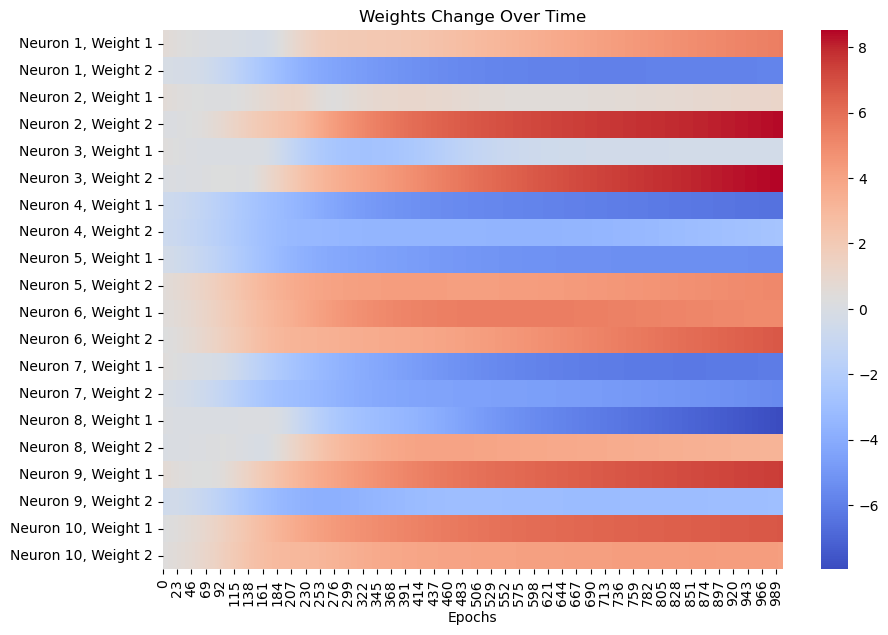

In [121]:
import seaborn as sns

# 获取每个神经元的权重值并转换为numpy数组
weight_matrix = [weights_np[:, i, :].T for i in range(hidden_dim)]
weight_matrix = np.vstack(weight_matrix)

plt.figure(figsize=(10, 7))
sns.heatmap(weight_matrix, cmap='coolwarm', cbar=True, yticklabels=[f"Neuron {i//input_dim+1}, Weight {i%input_dim+1}" for i in range(hidden_dim*input_dim)])
plt.xlabel("Epochs")
plt.title("Weights Change Over Time")
plt.show()

Class 1 Hidden Outputs Mean: [0.27002826 0.72097695 0.28917536 0.7113276  0.26017904 0.2954696
 0.2639683  0.24363135 0.27244312 0.7172541 ]
Class 1 Hidden Outputs Covariance:
 [[ 0.14270738 -0.05841563 -0.07701557 -0.01802229 -0.07039858 -0.04399494
  -0.0301741  -0.06583799  0.11513344  0.04685008]
 [-0.05841563  0.15070156  0.08085957 -0.0709083   0.06864904  0.08235438
  -0.0903687   0.05003949  0.00234865  0.07005969]
 [-0.07701557  0.08085957  0.15352687 -0.01285645  0.0774655   0.08772881
  -0.07387094  0.0245626  -0.06721942  0.07257119]
 [-0.01802229 -0.0709083  -0.01285645  0.1452369   0.06108052 -0.11400658
   0.07621843  0.06905468 -0.07830212 -0.08173036]
 [-0.07039858  0.06864904  0.0774655   0.06108052  0.13317377 -0.01833763
  -0.02709206  0.11240011 -0.07091225  0.0050245 ]
 [-0.04399494  0.08235438  0.08772881 -0.11400658 -0.01833763  0.15686134
  -0.07815543 -0.05515136  0.00789037  0.08357161]
 [-0.0301741  -0.0903687  -0.07387094  0.07621843 -0.02709206 -0.07815543

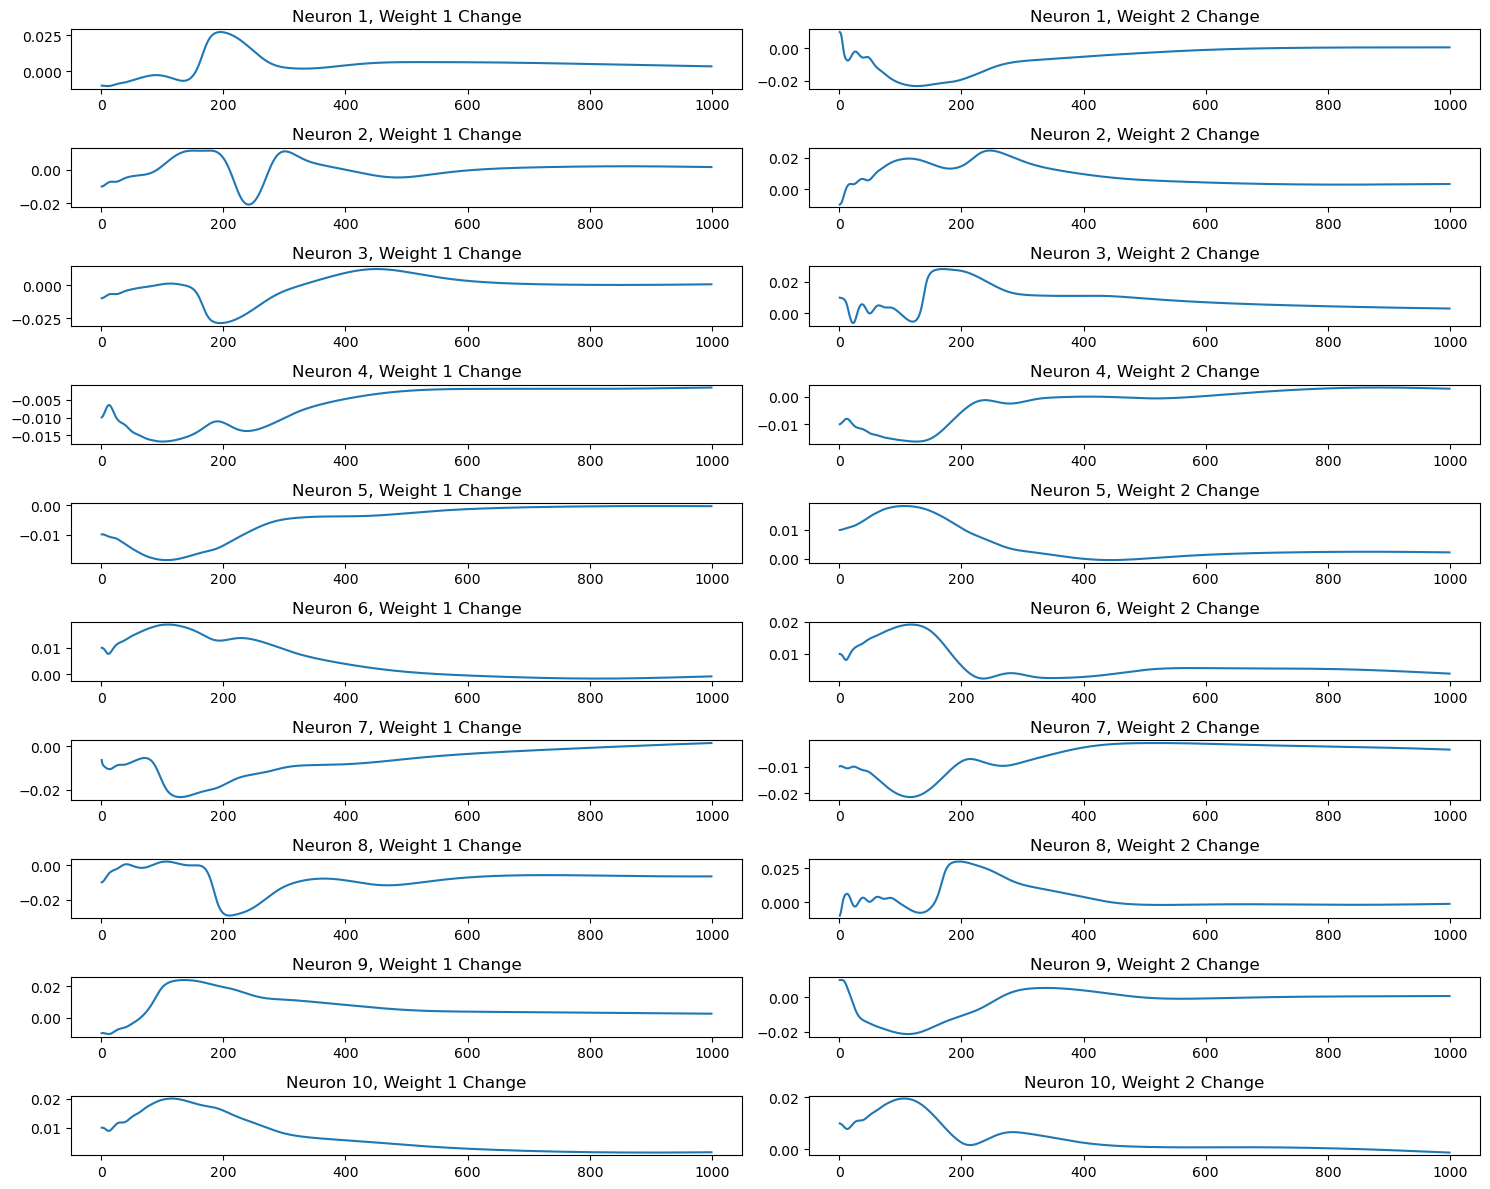

In [122]:
# 分类隐层输出
hidden_outputs_class_1 = hidden_outputs[y_train.squeeze() == 0]
hidden_outputs_class_2 = hidden_outputs[y_train.squeeze() == 1]

# 计算统计数据
mean_class_1 = np.mean(hidden_outputs_class_1, axis=0)
mean_class_2 = np.mean(hidden_outputs_class_2, axis=0)
cov_class_1 = np.cov(hidden_outputs_class_1, rowvar=False)
cov_class_2 = np.cov(hidden_outputs_class_2, rowvar=False)

# 打印结果
print("Class 1 Hidden Outputs Mean:", mean_class_1)
print("Class 1 Hidden Outputs Covariance:\n", cov_class_1)
print("Class 2 Hidden Outputs Mean:", mean_class_2)
print("Class 2 Hidden Outputs Covariance:\n", cov_class_2)

# 将权重转换为numpy数组进行分析
#weights_np = np.array([w.cpu().numpy() for w in weights])

# 计算权重变化的均值和标准差等统计数据
weight_changes = np.diff(weights_np, axis=0)  # Epoch间权重的变化
weight_changes_mean = weight_changes.mean(axis=0)
weight_changes_std = weight_changes.std(axis=0)

# 打印结果
print("Weight Changes Mean:\n", weight_changes_mean)
print("Weight Changes Std:\n", weight_changes_std)

# 可视化权重变化
plt.figure(figsize=(15, 12))
for i in range(weights_np.shape[1]):
    for j in range(weights_np.shape[2]):
        plt.subplot(weights_np.shape[1], weights_np.shape[2], i * weights_np.shape[2] + j + 1)
        plt.plot(range(1, epochs), weight_changes[:, i, j])
        plt.title(f'Neuron {i+1}, Weight {j+1} Change')
plt.tight_layout()
plt.show()


In [123]:

# Evaluate the model on the testing set
with torch.no_grad():
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    predicted_classes = (test_outputs > 0.5).float()
    accuracy = (predicted_classes == y_test).float().mean()

print(f'Test Loss: {test_loss.item():.4f}')
print(f'Test Accuracy: {accuracy.item()*100:.2f}%')

Test Loss: 0.0323
Test Accuracy: 99.50%


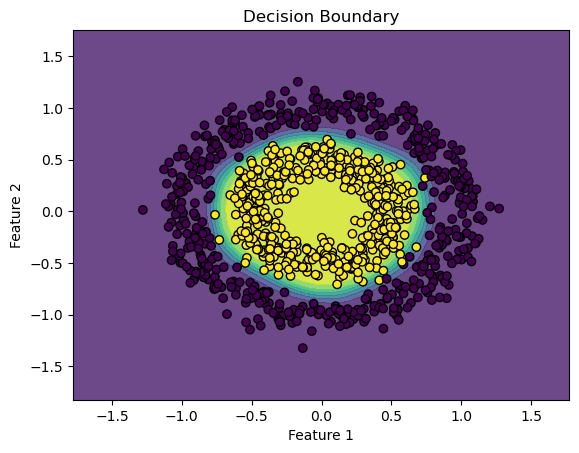

In [124]:
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float)
    
    with torch.no_grad():
        preds = model(grid)
    Z = preds.view(xx.shape).detach().numpy()

    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y.squeeze(), edgecolors='k')
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Decision Boundary")
    plt.show()

# 对整个数据集绘制决策边界
plot_decision_boundary(model, X, y)
